<a href="https://colab.research.google.com/github/Nyeonging/Camera_Pose_M/blob/main/DeepLearning_5_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchsummary import summary
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# Data

In [ ]:
# 파일 경로 설정
csv_file_path = "C:\\JES\\RC\\rc0610.csv" # 경로 맞게 수정 필요
image_folder = "C:\\JES\\RC\\vid\\Frames0605\\" # 경로 맞게 수정 필요

# CSV 파일 읽기
df = pd.read_csv(csv_file_path)                # CSV 파일을 DataFrame으로 읽기
df.iloc[:, 4:7] = np.deg2rad(df.iloc[:, 4:7])  # 각도를 라디안으로 변환

# 데이터프레임의 첫 몇 줄을 출력하여 확인하기
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\JES\\RC\\rc0610.csv'

Imagename: frame005260.png
x          -18.4569
y          6.071289
z          4.101486
heading     -2.7138
pitch      1.322224
roll      -0.252626
Name: 221, dtype: object
Image Path: C:\JES\RC\vid\Frames0605\frame005260.png
File Exists: True


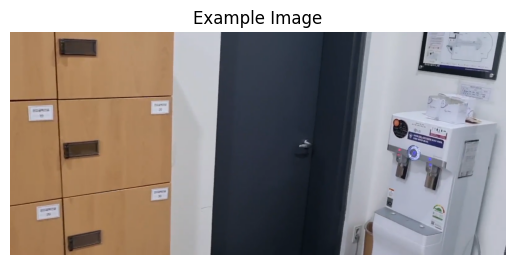

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

# 랜덤으로 하나의 이미지와 그에 해당하는 라벨을 선택하여 출력하기
random_index = random.randint(0, len(df) - 1)
print('Imagename:' ,df.iloc[random_index,0])
print(df.iloc[random_index,1:])

#시각화
image_name = df.iloc[random_index,0]
image_path = os.path.join(image_folder, image_name)

print("Image Path:", image_path)
print("File Exists:", os.path.exists(image_path))

image = cv2.imread(image_path)
if image is None:
    print("Error: Could not read the image. Please check the file path and file name.")
else:
    try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title('Example Image')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"An error occurred while processing the image: {e}")

## 데이터 분할

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터프레임의 컬럼명을 지정
df.columns = ['image', 'x', 'y', 'z', 'heading', 'pitch', 'roll'] # 이미지, 위치 및 포즈 정보 컬럼명

# 필요한 데이터를 float 타입으로 변환
df[['x', 'y', 'z', 'heading', 'pitch', 'roll']] = df[['x', 'y', 'z', 'heading', 'pitch', 'roll']].astype(float) # 수치 데이터로 다루기 위해 float 타입으로 변환

# 전체 데이터를 학습(0.8), 테스트 세트로 분할(0.2)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42) # 테스트 세트 20%
# 학습 세트를 다시 학습 세트와 검증 세트로 분할
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

print(f'Train set size: {len(train_data)}') # train(학습) : 60%
print(f'Validation set size: {len(val_data)}') # validation(검증) : 20%
print(f'Test set size: {len(test_data)}') # test : 20%

Train set size: 2064
Validation set size: 688
Test set size: 689


## 데이터 전처리

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

# PoseDataset 클래스 정의: 이미지와 라벨 로드, 전처리하는 역할
class PoseDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.dataframe.iloc[idx, 0]) # 이미지 파일 전체 경로
        image = Image.open(img_name).convert('RGB') # 이미지 열어서 RGB 로 변환
        labels = self.dataframe.iloc[idx, 1:].values.astype('float32') # 라벨 읽어와서 float32로
        labels = torch.tensor(labels, dtype=torch.float32) # 라벨 값을 Pytorch 텐서로
        if self.transform:
            image = self.transform(image) # 이미지 전처리
        return image, labels

# Data augmentation 및 변환 설정하기: 훈련 데이터에 적용할 변환 정의
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),                                                 # 이미지 크기 256x256 으로 -> 모델 입력 차원 통일
    transforms.RandomHorizontalFlip(),                                             # 이미지를 랜덤으로 수평 반전 -> 일반화 성능 향상시켜줌
    transforms.RandomRotation(10),                                                 # 이미지를 랜덤으로 10도 회전 -> 다양한 각도에서 이미지 인식할 수 있도록
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 컬러 조정
    transforms.ToTensor(),                                                         # 이미지를 PyTorch 텐서로 변환
])

# Transform for validation and test datasets : 데이터 전처리 정의
test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지 크기를 256x256
    transforms.ToTensor(),
])

# 데이터셋 및 데이터 로더
train_dataset = PoseDataset(dataframe=train_data, image_folder=image_folder, transform=train_transform) # 훈련 데이터셋 생성
val_dataset = PoseDataset(dataframe=val_data, image_folder=image_folder, transform=test_transform) # 검증 데이터셋 생성
test_dataset = PoseDataset(dataframe=test_data, image_folder=image_folder, transform=test_transform) # 테스트 데이터셋 생성

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#장치 설정해줌 (GPU 가능시 GPU 로)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델

## loss function & architecture

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import random
import math

# Custom Loss Function 정의
class CustomMinLoss(nn.Module):
    def __init__(self):
        super(CustomMinLoss, self).__init__()

    def forward(self, output, target):
        diff = (output - target)  # 예측값과 실제값의 차이 계산
        diff = torch.where(diff > torch.tensor(math.pi), diff - 2 * math.pi, diff)  # 0과 pi 사이의 차이 계산, 차이가 π보다 큰 경우, 2π를 빼준다
        diff = torch.where(diff < -torch.tensor(math.pi), diff + 2 * math.pi, diff)  # -pi와 0 사이의 차이 계산, 차이가 -π보다 작은 경우, 2π를 더한다
        diff = torch.abs(diff)  # 차이를 절댓값으로 변환
        return torch.mean(diff)  # 차이를 평균 계산하여 반환

# Mixed Loss Function 정의 (MSE + CustomMinLoss 가중 합)
class MixedLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(MixedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.custom_min_loss = CustomMinLoss()
        self.alpha = alpha # MSE loss 가중치
        self.beta = beta # CustomMinLoss 가중치

    def forward(self, output, target):
        mse_loss_value = self.mse_loss(output, target) # MSE 계산
        custom_min_loss_value = self.custom_min_loss(output, target) # CustomMinLoss 계산
        return self.alpha * mse_loss_value + self.beta * custom_min_loss_value # 두 loss 가중 합쳐서 반환

# ResNet50 기반으로 한 CameraPoseEstimationModel 정의
class CameraPoseEstimationModel(nn.Module):
    def __init__(self):
        super(CameraPoseEstimationModel, self).__init__()
        self.backbone = models.resnet50(pretrained=True)              # 사전 학습된 ResNet50 모델
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 6) # fc layer 를 6개의 output 뉴런으로

    def forward(self, x):
        x = self.backbone(x)                                          # 입력 데이터를 ResNet50 모델을 통해서 전달
        pos = x[:, :3]                                                # First 3 values for (x, y, z) 위치로 사용
        orient = x[:, 3:]                                             # Last 3 values for (yaw, pitch, roll) 포즈로 사용
        return pos, orient                                            # 위치와 포즈를 반환

# AdamW 라는 옵티마이저 로 weigth decay 적절히 적용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CameraPoseEstimationModel().to(device)
mixed_loss = MixedLoss(alpha=0.5, beta=0.5) # MixedLoss loss
optimizer = optim.AdamW(model.parameters(), lr=0.001) # AdamW optimizer, learning rate 설정
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
#학습률 감소 스케줄러(ReduceLROnPklateau) 추가 : 성능 향상이 없으면 학습률 줄여줌


# AdamW 라는 옵티마이저 로 weigth decay 적절히 적용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CameraPoseEstimationModel().to(device)
mixed_loss = MixedLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


c:\Users\seoze\anaconda3\envs\spike\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\seoze\anaconda3\envs\spike\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\seoze/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.60MB/s]


In [ ]:
# 모델 초기화
model = CameraPoseEstimationModel().to(device)
mixed_loss = MixedLoss(alpha=0.5, beta=0.5)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


## Performances

Epoch 1/100, Train Loss: 6.7519
Epoch 1/100, Validation Loss: 12.7401
Epoch 2/100, Train Loss: 5.2698
Epoch 2/100, Validation Loss: 6.6526
Epoch 3/100, Train Loss: 3.8007
Epoch 3/100, Validation Loss: 3.9335
Epoch 4/100, Train Loss: 3.4618
Epoch 4/100, Validation Loss: 4.9417
Epoch 5/100, Train Loss: 3.1147
Epoch 5/100, Validation Loss: 3.0900
Epoch 6/100, Train Loss: 2.7450
Epoch 6/100, Validation Loss: 2.0085
Epoch 7/100, Train Loss: 2.4132
Epoch 7/100, Validation Loss: 4.8618
Epoch 8/100, Train Loss: 2.2899
Epoch 8/100, Validation Loss: 2.2846
Epoch 9/100, Train Loss: 2.0847
Epoch 9/100, Validation Loss: 2.2901
Epoch 10/100, Train Loss: 2.0702
Epoch 10/100, Validation Loss: 1.7752
Epoch 11/100, Train Loss: 1.8283
Epoch 11/100, Validation Loss: 1.5285
Epoch 12/100, Train Loss: 1.9474
Epoch 12/100, Validation Loss: 4.6609
Epoch 13/100, Train Loss: 1.8549
Epoch 13/100, Validation Loss: 1.7164
Epoch 14/100, Train Loss: 1.5343
Epoch 14/100, Validation Loss: 1.1694
Epoch 15/100, Train Los

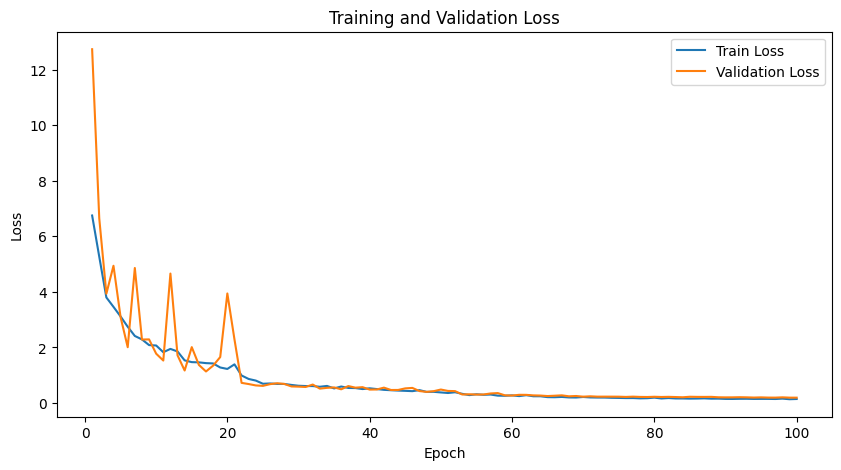

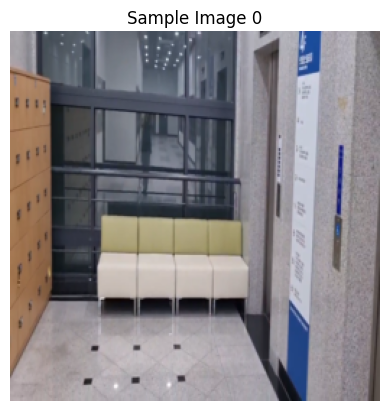

Actual Label: [ 4.088134    1.0339092   4.0678487   3.075007    1.4377356  -0.27350748]
Predicted Label: [ 4.199066   1.1926671  4.0406814  3.5716827  1.4479172 -0.3518135]


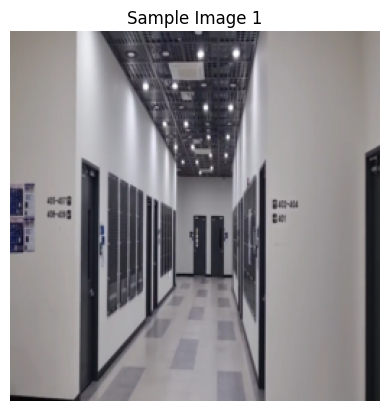

Actual Label: [ 3.6142933  1.1892773  3.9161615 -2.0012968  1.558037  -1.995136 ]
Predicted Label: [ 3.6262336  1.1965538  3.899478  -2.160426   1.5507002 -2.08704  ]


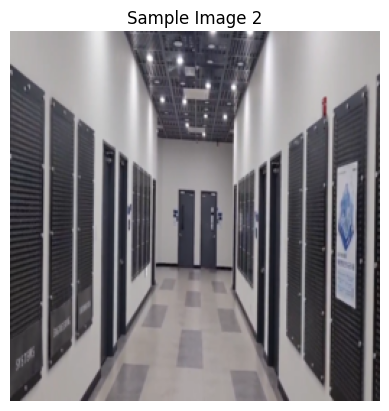

Actual Label: [ 2.4692326 13.824178   3.8776062 -0.9436151  1.5347879 -0.9951525]
Predicted Label: [ 2.471868  14.109152   3.921064  -0.9888727  1.5428932 -1.0732917]


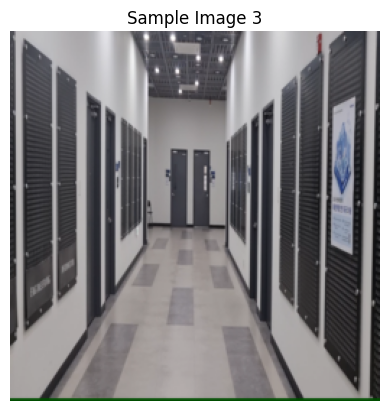

Actual Label: [ 2.7297573  14.574331    3.6929328  -0.21744074  1.502182   -0.28906304]
Predicted Label: [ 2.617692   14.605008    3.6639662  -0.17436084  1.491673   -0.24679032]


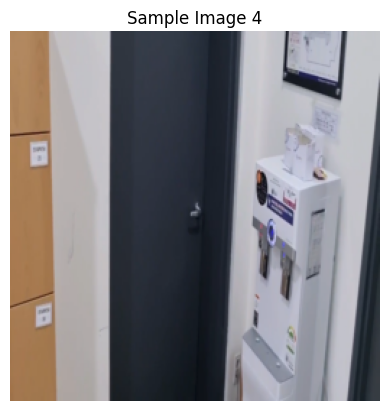

Actual Label: [-19.220448     6.1434846    4.1589794   -2.700737     1.2954742
  -0.25579125]
Predicted Label: [-19.310146     6.212824     3.9686222   -2.9157085    1.2837547
  -0.09991881]


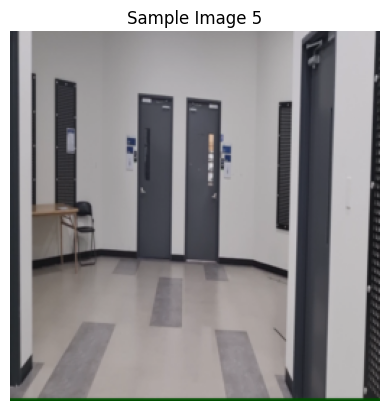

Actual Label: [ 4.0147133  38.600338    3.3930604  -0.2965846   1.4678696  -0.40323275]
Predicted Label: [ 4.1854186  38.81316     3.3990898  -0.29700577  1.4590677  -0.4376845 ]


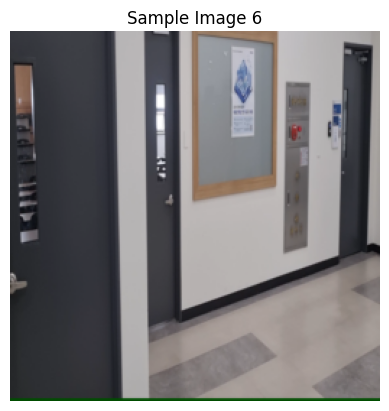

Actual Label: [-3.7313447  30.87255     3.0822003   2.207711    1.4613931   0.04743125]
Predicted Label: [-3.796635   30.904537    3.0432105   2.3726697   1.4571699   0.09796583]


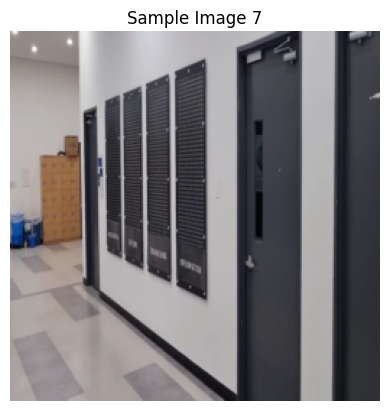

Actual Label: [ 6.0179725 38.217422   3.5057862 -2.13145    1.5062953  0.3583753]
Predicted Label: [ 6.157738  37.513966   3.4391563 -1.965003   1.4749358  0.3480196]


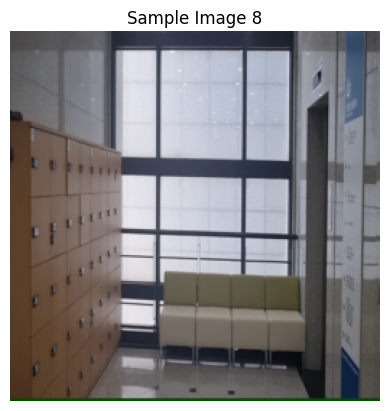

Actual Label: [ 3.5231524  1.7786613  3.8137946  2.767941   1.5409915 -0.3662302]
Predicted Label: [ 3.5959978  1.6130985  3.7801323  2.7803047  1.5223727 -0.2920595]


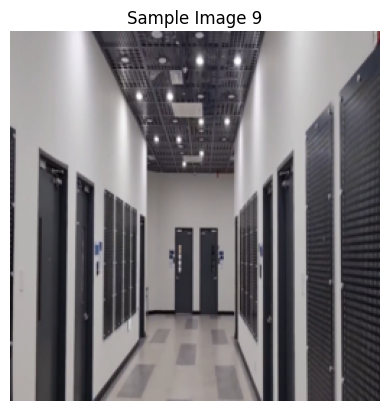

Actual Label: [ 3.624293  18.54474    3.7074764 -2.8762708  1.5314461 -2.917391 ]
Predicted Label: [ 3.7205057 18.648996   3.7713392 -2.9388695  1.5135907 -2.9193094]


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

train_losses = [] # 훈련 손실 값 저장 리스트
val_losses = [] # 검증 손실 값 저장 리스트

num_epochs = 100 # 에포크 설정
for epoch in range(num_epochs):
    model.train() # 학습 모드
    train_loss = 0.0 # 훈련 손실 값 초기화
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) # GPU로 데이터 이동
        optimizer.zero_grad() # 옵티마이저 기울기 초기화
        pos, orient = model(images) # 모델을 통해 위치와 포즈 예측
        loss = mixed_loss(torch.cat((pos, orient), dim=1), labels) # 손실 계산
        loss.backward() # 역전파
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # 기울기 폭주 방지
        optimizer.step() # 옵티마이저로 가중치 업데이트
        train_loss += loss.item() * images.size(0) # 배치 손실 값 누적

    train_loss /= len(train_loader.dataset) # 훈련 손실 평균 계산
    train_losses.append(train_loss) # 훈련 손실 리스트에 추가
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

    model.eval() # 평가 모드
    val_loss = 0.0 # 검증 손실 값 초기화
    with torch.no_grad(): # 평가 중에는 기울기 계산 안함
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            pos, orient = model(images)
            loss = mixed_loss(torch.cat((pos, orient), dim=1), labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Step the scheduler
    scheduler.step(val_loss)

    # Save the model checkpoint
    #save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_path)

# 손실 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 샘플 이미지와 예측 결과 시각화
indices = random.sample(range(len(test_dataset)), 10) # 테스트 데이터셋에서 랜덤으로 10개 샘플 선택
sample_images, sample_labels = zip(*[test_dataset[i] for i in indices]) # 샘플 이미지와 라벨 묶기
sample_images = torch.stack(sample_images).to(device)
sample_labels = torch.stack(sample_labels).to(device)

with torch.no_grad(): # 평가 중에는 기울기 계산 x
    sample_outputs = model(sample_images) # 모델을 통해 위치와 포즈 예측

for i in range(10):
    sample_image = sample_images[i].cpu().permute(1, 2, 0).numpy() # 이미지를 numpy 배열로 변환
    sample_label = sample_labels[i].cpu().numpy() # 라벨을 numpy 배열로 변환
    sample_output = torch.cat(sample_outputs, dim=1)[i].cpu().numpy() # 위치와 자세를 하나의 텐서로 결합하고 numpy 배열로 변환

    plt.figure()
    plt.imshow(sample_image)
    plt.title(f'Sample Image {i}')
    plt.axis('off')
    plt.show()

    print(f'Actual Label: {sample_label}')
    print(f'Predicted Label: {sample_output}')


In [ ]:
import torch

# Assuming `model` is your model instance
torch.save(model.state_dict(), 'model_state.pth')


# 결과 시각화

## Accuracy

In [ ]:
import numpy as np

# 정확도 계산 함수
def calculate_accuracy_with_threshold(model, data_loader, device, position_threshold, angle_threshold):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            pos, orient = model(images)

            # 위치 오차 계산
            position_error = torch.norm(pos - labels[:, :3], dim=1)

            # 각도 오차 계산
            angle_error = torch.norm(orient - labels[:, 3:], dim=1)

            # 정확도 계산
            correct += ((position_error < position_threshold) & (angle_error < np.deg2rad(angle_threshold))).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy


아래의 정확도 계산 코드 결과는 final_accuracy_ipynb 에

In [ ]:
# 다양한 임계값에 따른 정확도 계산
position_thresholds = np.arange(0.0, 3.1, 0.1)  # 0.5m 간격으로 0.5m ~ 10m 까지
angle_threshold = 360  # 각도 오차 임계값은 20도로 고정

accuracies = []

for pos_threshold in position_thresholds:
    accuracy = calculate_accuracy_with_threshold(model, test_loader, device, pos_threshold, angle_threshold)
    accuracies.append(accuracy)
    print(f'Position Threshold: {pos_threshold}, Accuracy: {accuracy:.2f}%')

# 정확도 시각화
plt.figure(figsize=(10, 5))
plt.plot(position_thresholds, accuracies, marker='o', label=f'Angle Threshold: {angle_threshold}°')
plt.xlabel('Position Threshold')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Position Threshold')
plt.legend()
plt.grid(True)
plt.show()

Position Threshold: 0.5m, Accuracy: 61.39%
Position Threshold: 1.0m, Accuracy: 78.81%
Position Threshold: 1.5m, Accuracy: 80.12%
Position Threshold: 2.0m, Accuracy: 80.41%
Position Threshold: 2.5m, Accuracy: 80.41%
Position Threshold: 3.0m, Accuracy: 80.55%
Position Threshold: 3.5m, Accuracy: 80.70%
Position Threshold: 4.0m, Accuracy: 80.70%
Position Threshold: 4.5m, Accuracy: 80.70%
Position Threshold: 5.0m, Accuracy: 80.70%
Position Threshold: 5.5m, Accuracy: 80.70%
Position Threshold: 6.0m, Accuracy: 80.70%
Position Threshold: 6.5m, Accuracy: 80.70%
Position Threshold: 7.0m, Accuracy: 80.70%
Position Threshold: 7.5m, Accuracy: 80.70%
Position Threshold: 8.0m, Accuracy: 80.70%
Position Threshold: 8.5m, Accuracy: 80.70%
Position Threshold: 9.0m, Accuracy: 80.70%
Position Threshold: 9.5m, Accuracy: 80.70%
Position Threshold: 10.0m, Accuracy: 80.70%


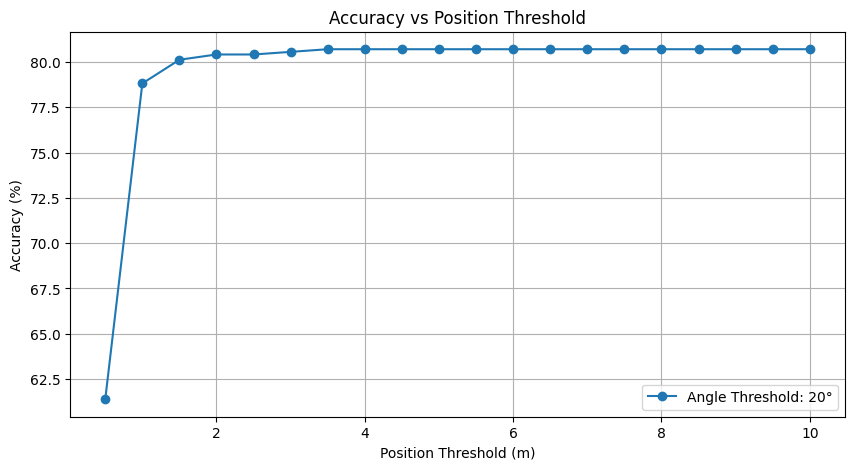

In [ ]:
# 다양한 임계값에 따른 정확도 계산
position_thresholds = np.arange(0.5, 10.5, 0.5)  # 0.5m 간격으로 0.5m ~ 10m 까지
angle_threshold = 20  # 각도 오차 임계값은 20도로 고정

accuracies = []

for pos_threshold in position_thresholds:
    accuracy = calculate_accuracy_with_threshold(model, test_loader, device, pos_threshold, angle_threshold)
    accuracies.append(accuracy)
    print(f'Position Threshold: {pos_threshold}m, Accuracy: {accuracy:.2f}%')

# 정확도 시각화
plt.figure(figsize=(10, 5))
plt.plot(position_thresholds, accuracies, marker='o', label=f'Angle Threshold: {angle_threshold}°')
plt.xlabel('Position Threshold (m)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Position Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from torchsummary import summary
from torchviz import make_dot

# 모델 요약 출력
model = CameraPoseEstimationModel().to(device)
summary(model, input_size=(3, 256, 256))

# 모델 구조 시각화
sample_input = torch.randn(1, 3, 256, 256).to(device)
pos, orient = model(sample_input)
output = torch.cat((pos, orient), dim=1)
make_dot(output, params=dict(model.named_parameters())).render("model_structure", format="png")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

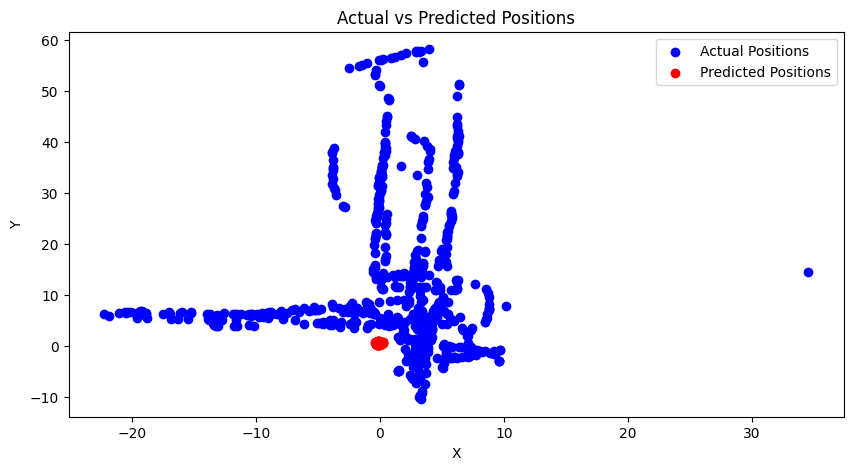

In [ ]:
#예측 결과 시각화
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, device):
    model.eval()
    actual_positions = []
    predicted_positions = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            pos, orient = model(images)
            actual_positions.extend(labels[:, :3].cpu().numpy())
            predicted_positions.extend(pos.cpu().numpy())

    actual_positions = np.array(actual_positions)
    predicted_positions = np.array(predicted_positions)

    plt.figure(figsize=(10, 5))
    plt.scatter(actual_positions[:, 0], actual_positions[:, 1], c='blue', label='Actual Positions')
    plt.scatter(predicted_positions[:, 0], predicted_positions[:, 1], c='red', label='Predicted Positions')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Actual vs Predicted Positions')
    plt.show()

# 예측 결과 시각화
visualize_predictions(model, test_loader, device)
